In [1]:
import sys
sys.path.append('/groups/umcg-wijmenga/tmp01/projects/lude_vici_2021/rawdata/non-coding-somatic-mutations-in-cancer/Anne/scripts/')
from Database import Database
# import multiprocessing as mp
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.distributions import chi2
from bioinfokit import analys, visuz
from scipy.stats import fisher_exact
import time
from scipy.special import factorial
import scipy.stats as stats
from scipy.stats import mannwhitneyu



from fisher import pvalue_npy
from scipy.stats import chi2_contingency
from scipy.stats import uniform, randint

In [2]:
colnames=['index', '#snps_b', 'chr', 'start_region', 'stop_region']
breast = pd.read_csv("D:/Hanze_Groningen/STAGE/R/PLOTS/kary/vs/before/1000_filter/breast_ALL_1000.tsv", sep='\t', header=None, names=colnames)
colnames=['index', '#snps_nb', 'chr', 'start_region', 'stop_region']
nonbreast = pd.read_csv("D:/Hanze_Groningen/STAGE/R/PLOTS/kary/vs/before/1000_filter/nonbreast_ALL_1000.tsv", sep='\t', header=None, names=colnames)

In [3]:
breast.dtypes

index           float64
#snps_b           int64
chr              object
start_region      int64
stop_region       int64
dtype: object

In [4]:
breast.sort_values(['chr', 'start_region'], inplace=True)
nonbreast.sort_values(['chr', 'start_region'], inplace=True)
merged_df = breast.merge(nonbreast, on=['chr', 'start_region', 'stop_region'], how='outer')
merged_df.drop(columns=['index_x', 'index_y'], inplace=True)

# 1000 split

In [5]:
merged_df

,index_x,#snps_b,chr,start_region,stop_region,index_y,#snps_nb
0,36547.0,0,chr1,1,1000,195812.0,0
1,36548.0,0,chr1,1001,2000,195813.0,0
2,36549.0,0,chr1,2001,3000,195814.0,0
3,36550.0,0,chr1,3001,4000,195815.0,0
4,36551.0,0,chr1,4001,5000,195816.0,0
...,...,...,...,...,...,...,...
3095684,59370.0,0,chrY,59369001,59370000,59370.0,0
3095685,59371.0,0,chrY,59370001,59371000,59371.0,0
3095686,59372.0,0,chrY,59371001,59372000,59372.0,0
3095687,59373.0,0,chrY,59372001,59373000,59373.0,0


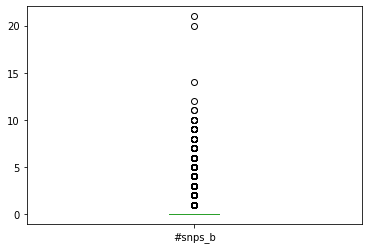

In [6]:
# https://www.reneshbedre.com/blog/mann-whitney-u-test.html
breast.boxplot(column=['#snps_b'], grid=False)
plt.show()

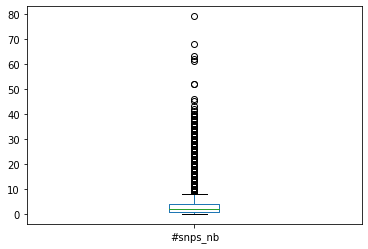

In [7]:
nonbreast.boxplot(column=['#snps_nb'], grid=False)
plt.show()

In [8]:
breast['filter_snps_b'] = breast['#snps_b']/ 286
nonbreast['filter_snps_nb'] = nonbreast['#snps_nb']/ 1952

C:\Users\Anne_\Anaconda3\envs\umap\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


w:0.45103782415390015, pvalue:0.0


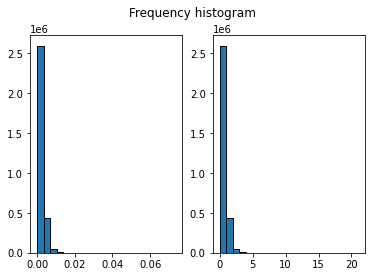

In [9]:
"""
As the p value obtained from the Shapiro-Wilk test is significant (p < 0.05), 
we conclude that the data is not normally distributed. Further, in histogram data 
distribution shape does not look normal. Therefore, Mann-Whitney U test is more appropriate for analyzing two samples.
"""
w, pvalue = stats.shapiro(breast['#snps_b'])
print(f'w:{w}, pvalue:{pvalue}')
# plot histogram
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Frequency histogram')
ax1.hist(breast['filter_snps_b'], bins=breast['#snps_b'].max(), histtype='bar', ec='k') 
ax2.hist(breast['#snps_b'], bins=breast['#snps_b'].max(), histtype='bar', ec='k') 
plt.show()

w:0.8885494470596313, pvalue:0.0


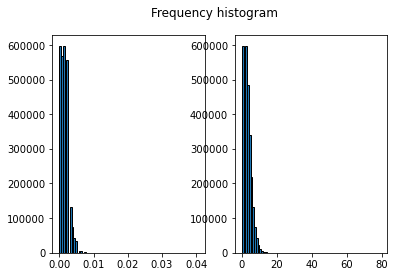

In [10]:
"""
As the p value obtained from the Shapiro-Wilk test is significant (p < 0.05), 
we conclude that the data is not normally distributed. Further, in histogram data 
distribution shape does not look normal. Therefore, Mann-Whitney U test is more appropriate for analyzing two samples.
"""
w, pvalue = stats.shapiro(nonbreast['#snps_nb'])
print(f'w:{w}, pvalue:{pvalue}')
# plot histogram
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Frequency histogram')
ax1.hist(nonbreast['filter_snps_nb'], bins=nonbreast['#snps_nb'].max(), histtype='bar', ec='k') 
ax2.hist(nonbreast['#snps_nb'], bins=nonbreast['#snps_nb'].max(), histtype='bar', ec='k') 
plt.show()

In [11]:

"""
Mann-Whitney U test interpretation: As the p value obtained from the Mann-Whitney U test 
is significant (U = 489.5, p < 0.05), we conclude that the yield of the two genotypes 
significantly different from each other .
"""
# U1, p = mannwhitneyu(list(breast['filter_snps']), list(nonbreast['filter_snps']), alternative = 'two-sided')
mannwhitneyu(list(breast['filter_snps_b']), list(nonbreast['filter_snps_nb']), alternative = 'two-sided')


MannwhitneyuResult(statistic=2256239622468.0, pvalue=0.0)

In [12]:
"""
As the p value obtained from the Mann-Whitney U test is significant (U = 489.5, p < 0.05), 
we conclude that the yield of the A genotype significantly greater than the genotype B.
"""
stats.mannwhitneyu(list(breast['filter_snps_b']), list(nonbreast['filter_snps_nb']), alternative = 'greater')

MannwhitneyuResult(statistic=2256239622468.0, pvalue=1.0)

# chi-square

In [13]:
merged_df['counts_breast_plus'] = merged_df['#snps_b'] + (1/286)
merged_df['counts_nonbreast_plus'] = merged_df['#snps_nb'] + (1/1952)

In [14]:
n = np.array([286, 1952])
S = merged_df[['counts_breast_plus', 'counts_nonbreast_plus']].to_numpy() #+1
f = n / n.sum()
E1 = S.sum(axis=1)[:,None]*f
C = (n-S)
E2 = C.sum(axis=1)[:,None]*f
D1 = ((E1-S)**2/E1).sum(axis=1)
D2 = ((E2-C)/E2).sum(axis=1)
X2 = D1 + D2
X2

array([0.01993941, 0.01993941, 0.01993941, ..., 0.01993941, 0.01993941,
       0.01993941])

In [20]:
S_C = np.concatenate((S, C), axis=1)
S_C

array([[3.49650350e-03, 5.12295082e-04, 2.85996503e+02, 1.95199949e+03],
       [3.49650350e-03, 5.12295082e-04, 2.85996503e+02, 1.95199949e+03],
       [3.49650350e-03, 5.12295082e-04, 2.85996503e+02, 1.95199949e+03],
       ...,
       [3.49650350e-03, 5.12295082e-04, 2.85996503e+02, 1.95199949e+03],
       [3.49650350e-03, 5.12295082e-04, 2.85996503e+02, 1.95199949e+03],
       [3.49650350e-03, 5.12295082e-04, 2.85996503e+02, 1.95199949e+03]])

In [15]:
p_value_X2 = chi2.sf(X2,1)

In [16]:
log10_p_value = -np.log10(p_value_X2)
log10_p_value

array([0.05173064, 0.05173064, 0.05173064, ..., 0.05173064, 0.05173064,
       0.05173064])

In [17]:
merged_df['X2'] = X2
merged_df['p_value_X2'] = p_value_X2
merged_df['log10_p_value'] = log10_p_value

In [18]:
merged_df

,index_x,#snps_b,chr,start_region,stop_region,index_y,#snps_nb,counts_breast_plus,counts_nonbreast_plus,X2,p_value_X2,log10_p_value
0,36547.0,0,chr1,1,1000,195812.0,0,0.003497,0.000512,0.019939,0.887706,0.051731
1,36548.0,0,chr1,1001,2000,195813.0,0,0.003497,0.000512,0.019939,0.887706,0.051731
2,36549.0,0,chr1,2001,3000,195814.0,0,0.003497,0.000512,0.019939,0.887706,0.051731
3,36550.0,0,chr1,3001,4000,195815.0,0,0.003497,0.000512,0.019939,0.887706,0.051731
4,36551.0,0,chr1,4001,5000,195816.0,0,0.003497,0.000512,0.019939,0.887706,0.051731
...,...,...,...,...,...,...,...,...,...,...,...,...
3095684,59370.0,0,chrY,59369001,59370000,59370.0,0,0.003497,0.000512,0.019939,0.887706,0.051731
3095685,59371.0,0,chrY,59370001,59371000,59371.0,0,0.003497,0.000512,0.019939,0.887706,0.051731
3095686,59372.0,0,chrY,59371001,59372000,59372.0,0,0.003497,0.000512,0.019939,0.887706,0.051731
3095687,59373.0,0,chrY,59372001,59373000,59373.0,0,0.003497,0.000512,0.019939,0.887706,0.051731


In [21]:
import time
start_time = time.perf_counter()

p_value_X2_TEST = list()
for index, value in enumerate(S_C):
    table = np.array([[value[0], value[2]], [value[1], value[3]]])
    stat, p, dof, expected = chi2_contingency(table)
    p_value_X2_TEST.append(p)
    if (index%100000) == 0:
        print(len(p_value_X2_TEST))
print(len(p_value_X2_TEST))

print("--- %s seconds ---" % (time.perf_counter() - start_time))
merged_df['p_value_X2_TEST'] = p_value_X2_TEST

1
100001
200001
300001
400001
500001
600001
700001
800001
900001
1000001
1100001
1200001
1300001
1400001
1500001
1600001
1700001
1800001
1900001
2000001
2100001
2200001
2300001
2400001
2500001
2600001
2700001
2800001
2900001
3000001
3095689
--- 729.1962176 seconds ---


# log2 fc

In [22]:
constant = np.log(n[0]) - np.log(n[1])
log2_fc = (np.log(S[:, 0]) - np.log(S[:, 1]) - constant) / np.log(2)
merged_df['log2_fc'] = log2_fc # log2(FC)
log2_fc

array([5.541732, 5.541732, 5.541732, ..., 5.541732, 5.541732, 5.541732])

# Fisher

In [23]:
import time
start_time = time.perf_counter()

p_value_F = list()
for index, value in enumerate(S_C):
    table = np.array([[value[0], value[2]], [value[1], value[3]]])
    oddsr, p = fisher_exact(table, alternative='two-sided')
    p_value_F.append(p)
    if (index%100000) == 0:
        print(len(p_value_F))
print(len(p_value_F))

print("--- %s seconds ---" % (time.perf_counter() - start_time))

1
100001
200001
300001
400001
500001
600001
700001
800001
900001
1000001
1100001
1200001
1300001
1400001
1500001
1600001
1700001
1800001
1900001
2000001
2100001
2200001
2300001
2400001
2500001
2600001
2700001
2800001
2900001
3000001
3095689
--- 1488.5139399000002 seconds ---


In [27]:
merged_df['p_value_F'] = p_value_F
print(merged_df['p_value_F'].corr(merged_df['p_value_X2']))
print(merged_df['p_value_F'].corr(merged_df['p_value_X2_TEST']))

0.6279908449821555
-0.11364516058170371


In [26]:
merged_df.to_csv(f"D:/Hanze_Groningen/STAGE/R/chrom_split_1000.tsv", sep='\t', encoding='utf-8', index=False)

# Volcano plot

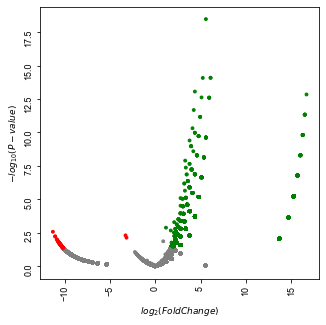

In [28]:
plt = visuz.GeneExpression.volcano(df=merged_df,lfc='log2_fc',pv='p_value_X2',show=True)


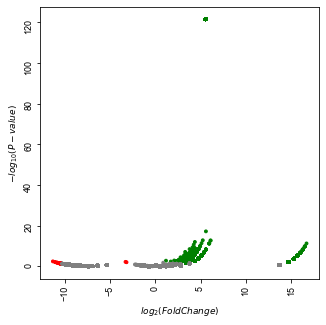

In [29]:
plt = visuz.GeneExpression.volcano(df=merged_df,lfc='log2_fc',pv='p_value_X2_TEST',show=True)


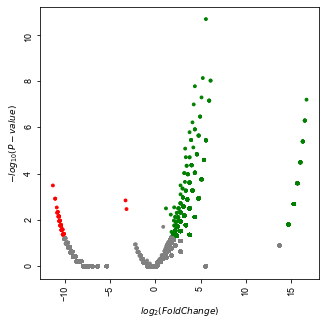

In [30]:
plt = visuz.GeneExpression.volcano(df=merged_df,lfc='log2_fc',pv='p_value_F',show=True)
